In [389]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import itertools
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor, Pool
import seaborn as sns
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

%matplotlib inline

data_labeled = pd.read_csv('Freezing_Fritz_2023/data_train_Temperature.csv')
data_unlabeled = pd.read_csv('Freezing_Fritz_2023/data_test_Temperature.csv')

data_labeled_np = data_labeled.to_numpy()


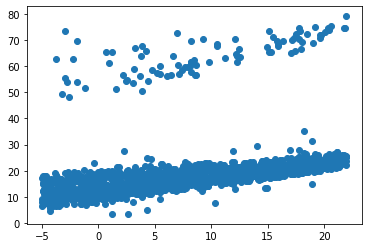

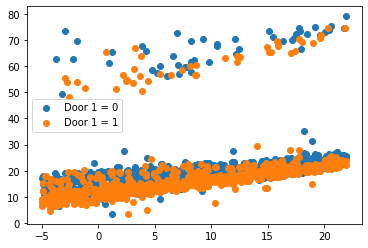

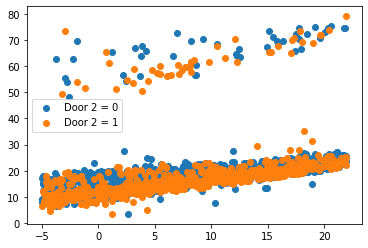

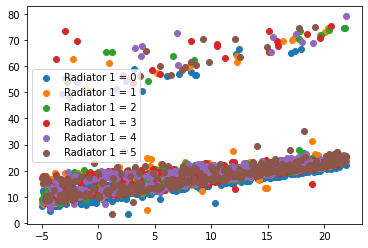

,Window 1,Window 2,Window 3,Window 4,Heat Control 1,Heat Control 2,Heat Control 3,Heat Control 4,Door 1,Door 2,Door 3,Temperature Outside,Temperature Bed
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,0.498082,0.503014,0.488219,0.498630,2.435068,2.510137,2.490411,2.471233,0.503014,0.481644,0.496438,8.365149,19.543798
std,0.500133,0.500128,0.499998,0.500135,1.745382,1.721584,1.695272,1.709548,0.500128,0.499800,0.500124,7.758904,11.238619
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.996860,3.521210
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.654068,14.149120
50%,0.000000,1.000000,0.000000,0.000000,2.000000,3.000000,3.000000,3.000000,1.000000,0.000000,0.000000,8.492403,17.932720
75%,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,15.141033,21.061605
max,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,21.972642,79.088778


In [390]:
# DATA VISUALIZATION

plt.scatter(data_labeled_np[:,11],data_labeled_np[:,12])
plt.show()
   
filter0 = data_labeled_np[:,8] == 0
filter1 = data_labeled_np[:,8] == 1
   
plt.scatter(data_labeled_np[filter0,11],data_labeled_np[filter0,12],label = "Door 1 = 0")
plt.scatter(data_labeled_np[filter1,11],data_labeled_np[filter1,12],label = "Door 1 = 1")
plt.legend()
plt.show()

filter0 = data_labeled_np[:,9] == 0
filter1 = data_labeled_np[:,9] == 1
   
plt.scatter(data_labeled_np[filter0,11],data_labeled_np[filter0,12],label = "Door 2 = 0")
plt.scatter(data_labeled_np[filter1,11],data_labeled_np[filter1,12],label = "Door 2 = 1")
plt.legend()
plt.show()

filter0 = data_labeled_np[:,4] == 0
filter1 = data_labeled_np[:,4] == 1
filter2 = data_labeled_np[:,4] == 2
filter3 = data_labeled_np[:,4] == 3
filter4 = data_labeled_np[:,4] == 4
filter5 = data_labeled_np[:,4] == 5
   
plt.scatter(data_labeled_np[filter0,11],data_labeled_np[filter0,12],label = "Radiator 1 = 0")
plt.scatter(data_labeled_np[filter1,11],data_labeled_np[filter1,12],label = "Radiator 1 = 1")
plt.scatter(data_labeled_np[filter2,11],data_labeled_np[filter2,12],label = "Radiator 1 = 2")
plt.scatter(data_labeled_np[filter3,11],data_labeled_np[filter3,12],label = "Radiator 1 = 3")
plt.scatter(data_labeled_np[filter4,11],data_labeled_np[filter4,12],label = "Radiator 1 = 4")
plt.scatter(data_labeled_np[filter5,11],data_labeled_np[filter5,12],label = "Radiator 1 = 5")
plt.legend()
plt.show()

data_labeled.describe()


In [391]:
def split_by_feature(dataset, feature_index, min_size = 15):
   
   unique_feature_values = list(set(data_point[feature_index] for data_point in dataset))
    
   splits = []
   
   for value in unique_feature_values:
      split = np.array([data_point for data_point in dataset if data_point[feature_index] == value])
      if len(split) >= min_size:
         splits.append(split)
      else:
         return [dataset]
   return splits
   

In [392]:
def RMSE_polynomial(dataset, degree, threshold):
    x = dataset[:, -2]  # Extract the second-to-last column as the x-values
    y = dataset[:, -1]  # Extract the last column as the y-values

    # Create the polynomial features
    X = np.vander(x, degree + 1, increasing=True)

    # Perform polynomial regression
    coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    # Scatter plot the points
    residuals = y - np.polyval(coefficients[::-1], x)
    filter = np.abs(residuals) <= threshold*np.std(residuals)

    # Create a new dataset without points where the residual is larger than the threshold*std
    new_dataset = dataset[filter]

    # Calculate RMSE of the new dataset
    new_x = new_dataset[:, -2]
    new_y = new_dataset[:, -1]
    new_y_predicted = np.polyval(coefficients[::-1], new_x)
    new_rmse = np.sqrt(np.mean((new_y - new_y_predicted) ** 2))

    return new_rmse, coefficients, filter

In [393]:
def split_by_polynomial(dataset, feature_indices, dictionary, degree = 1, min_size = 15, key = [], threshold = 3):
   
   mean_rmses = {}
   
   for feature_index in feature_indices:
      
      splits = split_by_feature(dataset, feature_index, min_size)
      
      mean_rmse = 0
      
      for split in splits:
         
         rmse, coefs, filter = RMSE_polynomial(split, degree, threshold)
         
         mean_rmse += rmse
            
      mean_rmse = mean_rmse/len(splits)
      
      mean_rmses[feature_index] = mean_rmse
      
   feature_index_of_lowest_mean_rmse = min(mean_rmses, key=lambda k: mean_rmses[k])
   
   final_splits = split_by_feature(dataset, feature_index_of_lowest_mean_rmse, min_size)
   
   if len(final_splits) == 1:
      dictionary[tuple(key)] = final_splits[0]
      
   else: 
      for split in final_splits:
         feature_value = split[0][feature_index_of_lowest_mean_rmse]
         new_key = key+[(feature_index_of_lowest_mean_rmse, feature_value)]
         split_by_polynomial(split, feature_indices, dictionary, degree, min_size, new_key, threshold)

In [394]:
# DATA CLEANING

#Filter all Datapoints where T-Bed < T-Outside
filter = data_labeled_np[:,11] < data_labeled_np[:,12] 
faulty_data = data_labeled_np[~filter]
data_labeled_np = data_labeled_np[filter]


#Filter all Datapoints where T-Bed > 40
filter = data_labeled_np[:,12] < 40 
faulty_data = np.row_stack((faulty_data, data_labeled_np[~filter]))
over40 = data_labeled_np[~filter]
data_labeled_np = data_labeled_np[filter]


#Create new data from linear transforming samples with T-Bed > 40 to fahrenheit
over40[:, 12] -= 32
over40[:, 12] *= 5/9
data_labeled_np = np.concatenate((data_labeled_np, over40))

#Filter outliers global
rmse, coefs, filter = RMSE_polynomial(data_labeled_np, degree = 1, threshold = 3)
faulty_data = np.row_stack((faulty_data, data_labeled_np[~filter]))
data_labeled_np = data_labeled_np[filter]

#Create subset ditionary according to best polynomial approximation of splits 
dictionary_subsets = {}
feature_indices = [0,1,2,3,4,5,6,7,8,9,10]
split_by_polynomial(data_labeled_np, feature_indices, dictionary_subsets, degree = 3, min_size = 15)


#Filter outliers per split
sum_rmse = 0
count = 0
verbose = 0

for key in dictionary_subsets:
   
   subset = dictionary_subsets[key]
   rmse, coefs, filter = RMSE_polynomial(subset,degree = 1,threshold = 2.2)
   sum_rmse += rmse
   faulty_data = np.row_stack((faulty_data, subset[~filter]))
   new_subset = subset[filter]
   dictionary_subsets[key] = new_subset
   
   
   if rmse > 0.9:
      count += 1
      if verbose == 1: 
         print("dictionary key: ", key)
         print("Root mean squared error: ", rmse)
         plt.scatter(new_subset[:, 11],new_subset[:, 12], c='blue', label='Residual <= Threshold*std')
         plt.scatter(subset[~filter][:, 11], subset[~filter][:, 12], c='orange', label='Residual > Threshold*std')

         x_values = np.linspace(-5, 25, 100)
         y_values = np.polyval(coefs[::-1], x_values)
         plt.plot(x_values, y_values, color='red', label='Polynomial Regression')

         plt.ylim(0, 35)
         plt.xlim(-5,25)
         plt.show()
         
   if verbose == 2: 
         print("dictionary key: ", key)
         print("Root mean squared error: ", rmse)
         plt.scatter(new_subset[:, 11],new_subset[:, 12], c='blue', label='Residual <= Threshold*std')
         plt.scatter(subset[~filter][:, 11], subset[~filter][:, 12], c='orange', label='Residual > Threshold*std')

         x_values = np.linspace(-5, 25, 100)
         y_values = np.polyval(coefs[::-1], x_values)
         plt.plot(x_values, y_values, color='red', label='Polynomial Regression')

         plt.ylim(0, 35)
         plt.xlim(-5,25)
         plt.show()

data_labeled_np = np.concatenate(tuple(list(dictionary_subsets.values())))

#Print stats about splitting
print("Total number of subsets: ", len(dictionary_subsets))
print("Subsets with rmse < 0.9: " ,len(dictionary_subsets) - count)
print("Subsets with rmse > 0.9: ", count)
print("Mean rmse: ", sum_rmse / len(dictionary_subsets))

Total number of subsets:  82
Subsets with rmse < 0.9:  57
Subsets with rmse > 0.9:  25
Mean rmse:  0.8024861459661657


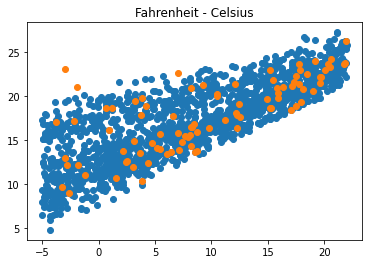

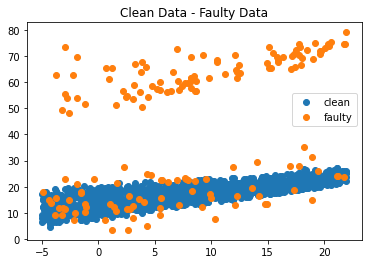

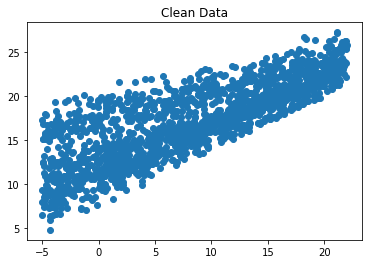

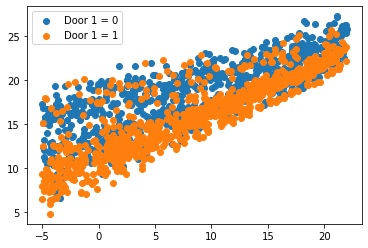

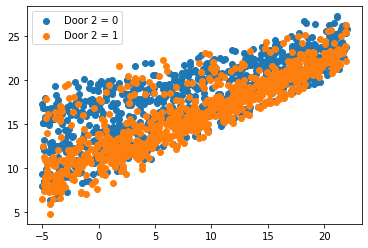

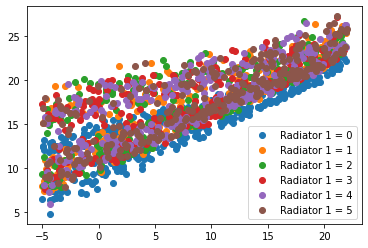

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000,1751.000000
mean,0.495717,0.504283,0.485437,0.499714,2.430040,2.499714,2.476870,2.456882,0.502570,0.482581,0.493432,8.472195,17.241704
std,0.500124,0.500124,0.499931,0.500143,1.742114,1.720424,1.702236,1.716890,0.500136,0.499839,0.500100,7.754960,4.289392
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.996860,4.817258
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.748253,14.059023
50%,0.000000,1.000000,0.000000,0.000000,2.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,8.660233,17.695522
75%,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,4.000000,1.000000,1.000000,1.000000,15.211998,20.577926
max,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,21.972642,27.200921


In [395]:
# CLEANED DATA VISUALIZATION

plt.scatter(data_labeled_np[:, 11], data_labeled_np[:, 12])
plt.scatter(over40[:, 11], over40[:, 12])
plt.title("Fahrenheit - Celsius")
plt.show()

plt.scatter(data_labeled_np[:,11],data_labeled_np[:,12],label = "clean")
plt.scatter(faulty_data[:,11],faulty_data[:,12],label = "faulty")
plt.title("Clean Data - Faulty Data")
plt.legend(loc='center right', bbox_to_anchor=(1, 0.6))
plt.show()

plt.scatter(data_labeled_np[:,11],data_labeled_np[:,12])
plt.title("Clean Data")
plt.show()
   
filter0 = data_labeled_np[:,8] == 0
filter1 = data_labeled_np[:,8] == 1
   
plt.scatter(data_labeled_np[filter0,11],data_labeled_np[filter0,12],label = "Door 1 = 0")
plt.scatter(data_labeled_np[filter1,11],data_labeled_np[filter1,12],label = "Door 1 = 1")
plt.legend()
plt.show()

filter0 = data_labeled_np[:,9] == 0
filter1 = data_labeled_np[:,9] == 1
   
plt.scatter(data_labeled_np[filter0,11],data_labeled_np[filter0,12],label = "Door 2 = 0")
plt.scatter(data_labeled_np[filter1,11],data_labeled_np[filter1,12],label = "Door 2 = 1")
plt.legend()
plt.show()

filter0 = data_labeled_np[:,4] == 0
filter1 = data_labeled_np[:,4] == 1
filter2 = data_labeled_np[:,4] == 2
filter3 = data_labeled_np[:,4] == 3
filter4 = data_labeled_np[:,4] == 4
filter5 = data_labeled_np[:,4] == 5

fig = plt.figure()
ax = fig.add_subplot(111)
   
ax.scatter(data_labeled_np[filter0,11],data_labeled_np[filter0,12],label = "Radiator 1 = 0")
ax.scatter(data_labeled_np[filter1,11],data_labeled_np[filter1,12],label = "Radiator 1 = 1")
ax.scatter(data_labeled_np[filter2,11],data_labeled_np[filter2,12],label = "Radiator 1 = 2")
ax.scatter(data_labeled_np[filter3,11],data_labeled_np[filter3,12],label = "Radiator 1 = 3")
ax.scatter(data_labeled_np[filter4,11],data_labeled_np[filter4,12],label = "Radiator 1 = 4")
ax.scatter(data_labeled_np[filter5,11],data_labeled_np[filter5,12],label = "Radiator 1 = 5")
ax.legend()
plt.show()

data_labeled_clean = pd.DataFrame(data_labeled_np)
data_labeled_clean.describe()

In [396]:
def find_matching_key(dictionary, datapoint):
    for key in dictionary.keys():
        match = True
        for index, value in key:
            if datapoint[index] != value:
                match = False
                break
        if match:
            return key
    return None

In [397]:
# MODEL TRAINING

X = data_labeled_clean.iloc[:, :-1]
y = data_labeled_clean.iloc[:, -1]

N = 1
  
mean_rmse = 0

for i in range(N):
    
    print(f"Model {i} is being trained")
     
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_test = X_test.to_numpy()
    data_train_np = np.column_stack((X_train.to_numpy(), y_train.to_numpy()))

    model_dictionary = {}

    # dictionary mit subsets durch data_train
    subsets = {}
    feature_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    split_by_polynomial(data_train_np, feature_indices,subsets, 1, 150, threshold=100)

    #print("Number of subsets: ", len(subsets))

    # train model on every split
    for key in subsets:
        
        start = time.time()

        subset = subsets[key]
        X_subset = subset[:, :-1]
        y_subset = np.ravel(subset[:, -1:])
        
        key_feature_indices = [index for (index, value) in key]

        # Define the CatBoostRegressor
        model = CatBoostRegressor(ignored_features = key_feature_indices, verbose=False)

        # Define the parameter grid for GridSearchCV
        param_grid = {
            'learning_rate': np.round(np.linspace(0.005,0.1, 10),3),
            'depth': [1, 2, 3, 4],
            'iterations': range(600, 2000, 100)
        }

        # Perform GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_subset, y_subset)

        # Get the best parameters and the best score
        best_params = grid_search.best_params_
        best_score = -grid_search.best_score_
        best_depth = best_params["depth"]
        best_iterations = best_params["iterations"]
        best_learning_rate = best_params["learning_rate"]

        # print("Best parameters used for this model: ", best_params)
        print(f"Model {i}, Key: {key}, RMSE: {round((best_score)**(1/2),3)}, depth: {best_depth}, iterations: {best_iterations}, learning rate: {best_learning_rate}")
        print(f"this took {time.time()-start} seconds")

        # Train the CatBoost model with the best parameters
        best_model = CatBoostRegressor(**best_params, verbose=0)
        best_model.fit(X_subset, y_subset)

        model_dictionary[key] = best_model
        
    y_pred = []

    for datapoint in X_test:
        key = find_matching_key(model_dictionary, datapoint)
        pred = model_dictionary[key].predict([datapoint])
        y_pred.append(pred)
        
    y_pred = np.array(y_pred)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mean_rmse += rmse
    
mean_rmse /= N

print(f"\nMean rmse: {mean_rmse}")
   

Model 0 is being trained
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
